In [20]:
from IPython.display import Image
from openseespy import opensees
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import gzip
from streng.ppp.sections.geometry.tee import TeeSectionGeometry
from streng.ppp.sections.geometry.rectangular import RectangularSectionGeometry
from streng.ppp.opensees.pre.elements.modified_ibarra_krawinkler import ModifiedIbarraKrawinkler

Η αρίθμηση κόμβων, δομικών στοιχείων και πρόσθετων κόμβων για τα στοιχεία μηδενικού μήκους φαίνονται στο παρακάτω σχήμα

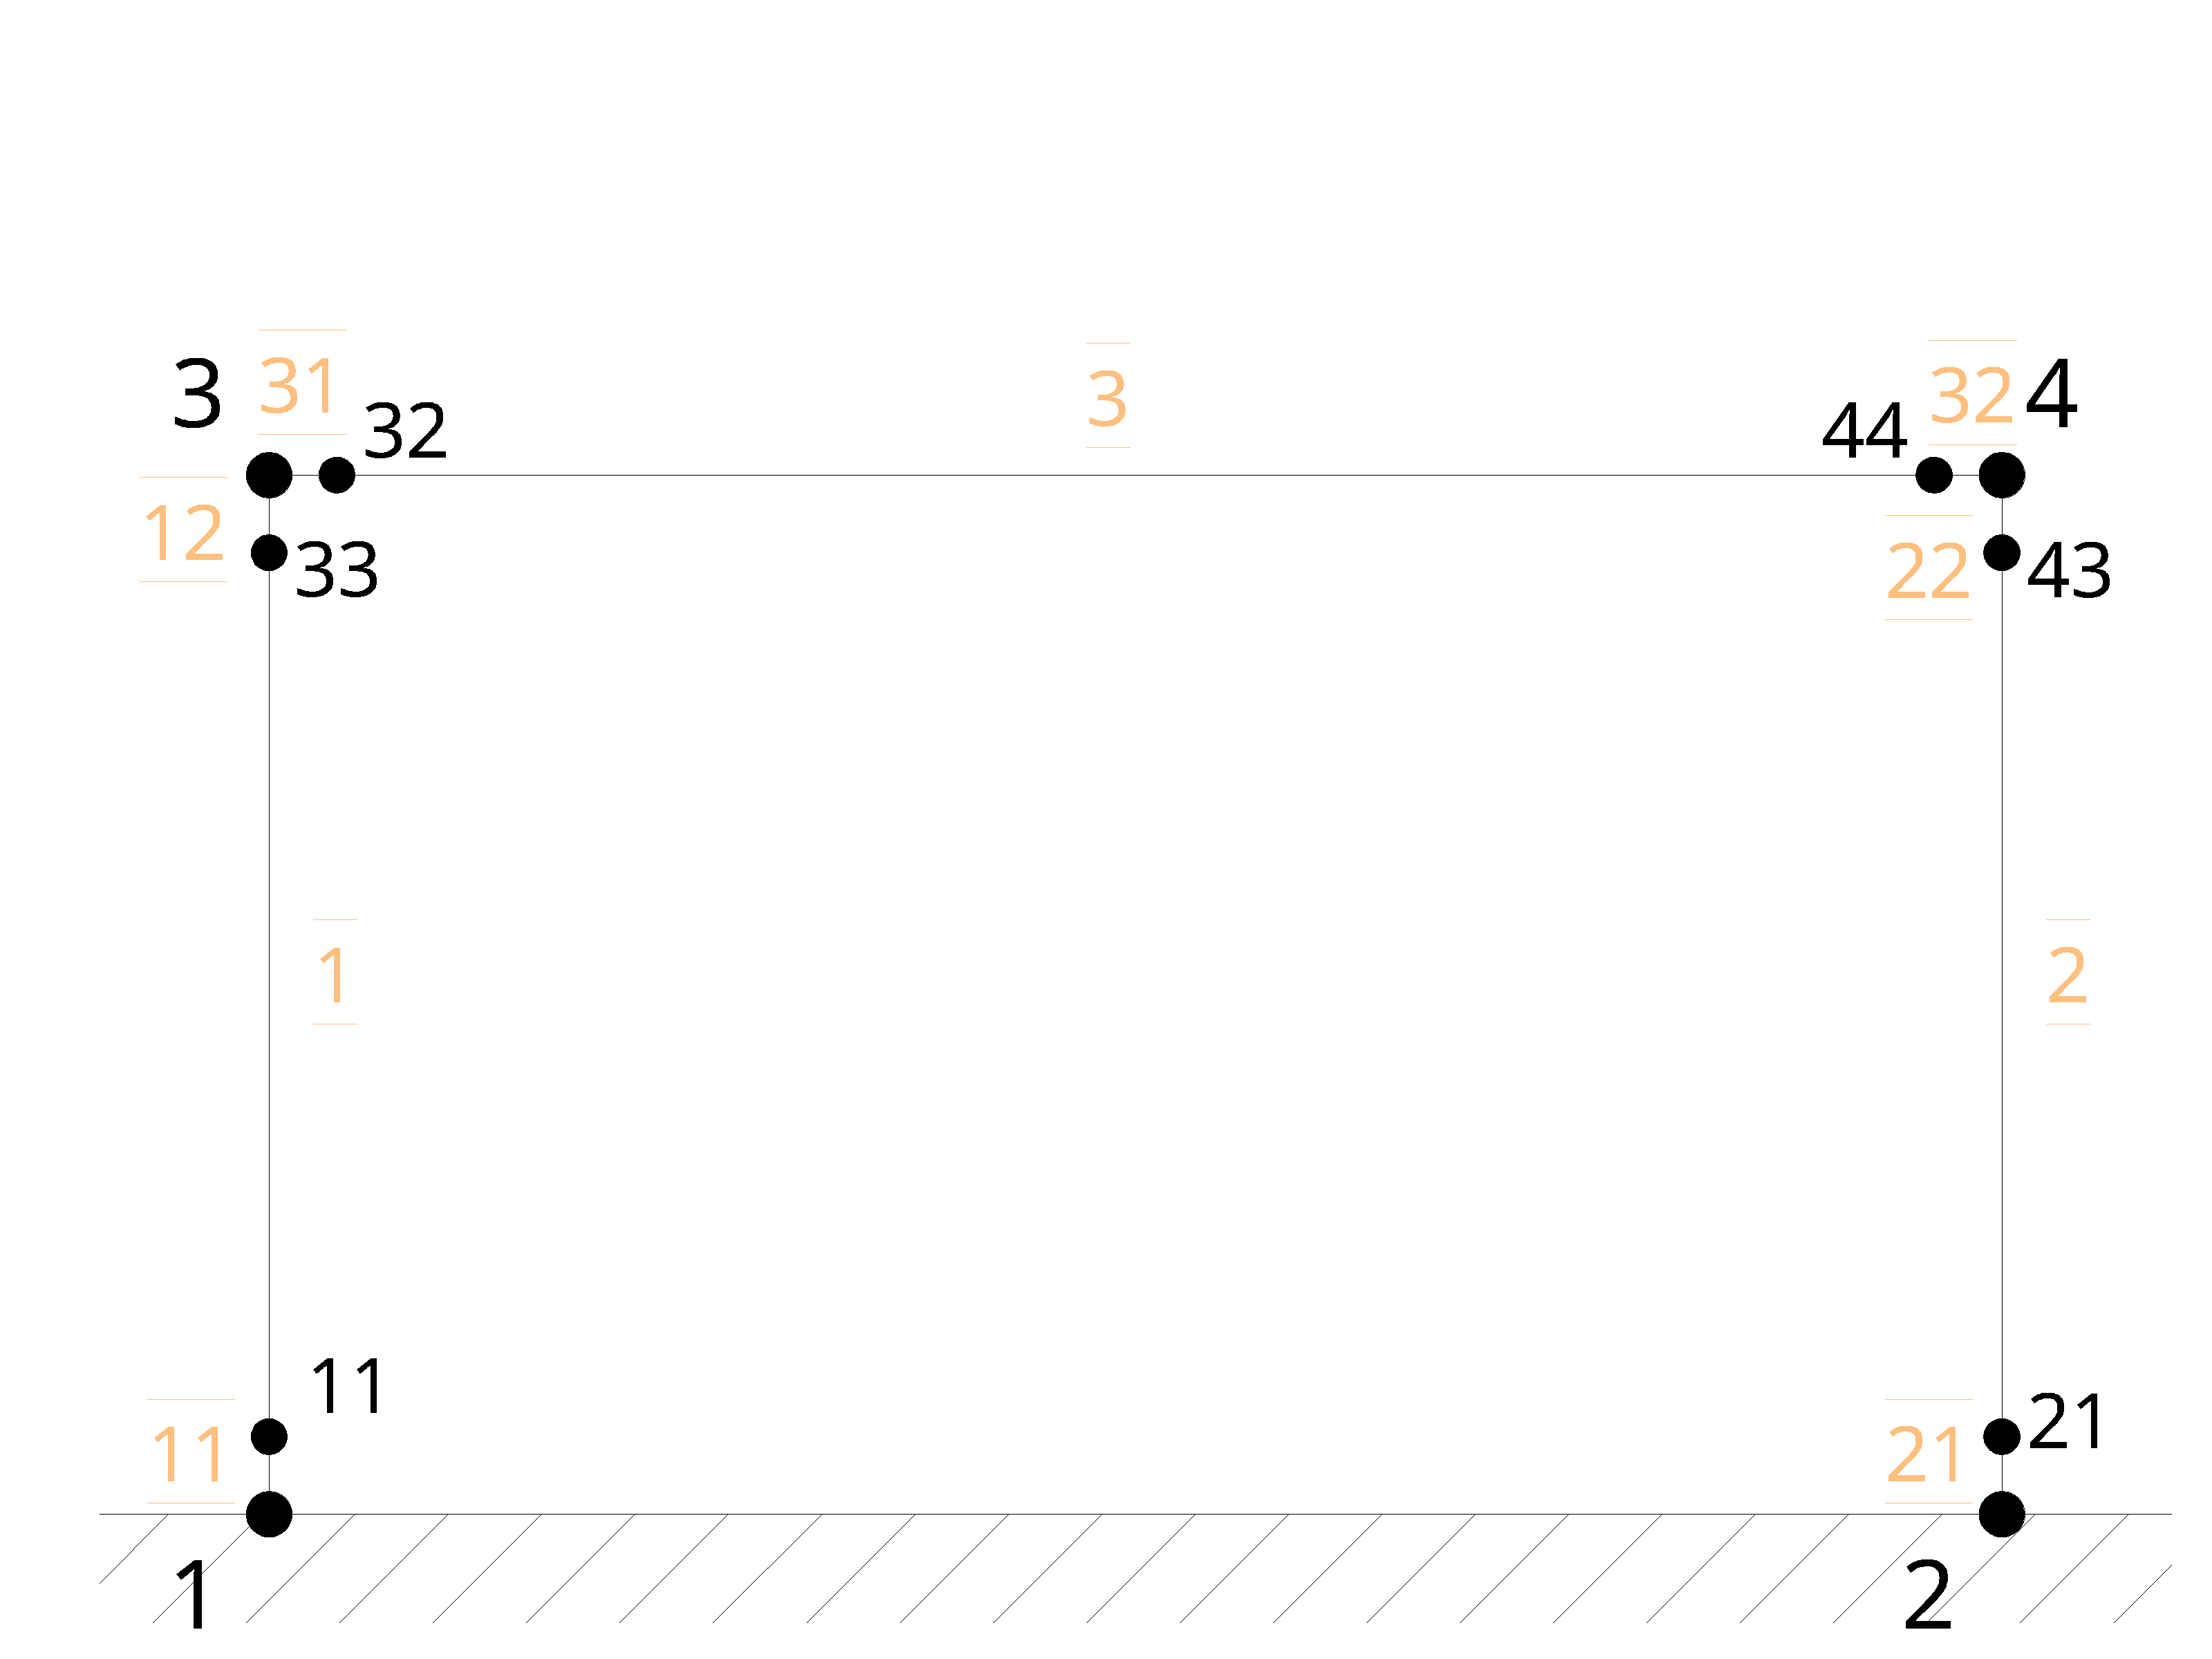

In [21]:
Image('opensees/nodes_elements.png', width=600)

In [22]:
E = 30000000.
U = 0.0
G = E / (2.0*(1.0+U))

# Βάζω μειωτικό συντελεστή 0.5 στη δυσκαμψία της δοκόύ
tbeam = TeeSectionGeometry(bw=0.25, h=0.70, beff=1.20, hf=0.15)
beam_A = tbeam.bw * tbeam.h 
beam_I = tbeam.moment_of_inertia_xx * 0.5
beam_sheararea = tbeam.shear_area_2

beam_My_pos=100.15
beam_Mu_pos=1.1*beam_My_pos
beam_θp_pos=0.025
beam_θpc_pos=0.030

beam_My_neg=146.36
beam_Mu_neg=1.1*beam_My_neg
beam_θp_neg=0.025
beam_θpc_neg=0.030


# Χωρίς μειωτικό συντελεστή για τη δυσκαμψία του στύλου
col = RectangularSectionGeometry(b=0.40, h=0.40)
col_A = col.area
col_I = col.moment_of_inertia_xx
col_sheararea = col.shear_area_2

col_My=236.97
col_Mu=1.1*col_My
col_θp=0.02
col_θpc=0.024

# Συντελεστ΄ής n για μοντέλο MIK
n_MIK = 10.
beam_I = beam_I * (n_MIK+1.0) / n_MIK
col_I = col_I * (n_MIK+1.0) / n_MIK

In [23]:
# General
opensees.wipe()
opensees.model('Basic', '-ndm', 2)
opensees.geomTransf('Linear', 1)

In [24]:
# Nodes
opensees.node(1, 0., 0.)
opensees.node(2, 5., 0.)
opensees.node(3, 0., 3.)
opensees.node(4, 5., 3.)

# extranodes
opensees.node(11, 0., 0.)
opensees.node(21, 5., 0.)
opensees.node(32, 0., 3.)
opensees.node(33, 0., 3.)
opensees.node(43, 5., 3.)
opensees.node(44, 5., 3.)

In [25]:
# Node fixes
opensees.fix(1, 1, 1, 1)
opensees.fix(2, 1, 1, 1)

In [26]:
# Nodal masses
opensees.mass(3, 11.723, 1.0e-10, 1.0e-10)

In [27]:
# Diaphragm - equalDOFs
opensees.equalDOF(3, 4, 1)

In [28]:
# ElasticTimoshenkoBeams
opensees.element('ElasticTimoshenkoBeam', 1, 11, 33, E, G, col_A, col_I, col_sheararea, 1) 
opensees.element('ElasticTimoshenkoBeam', 2, 21, 43, E, G, col_A, col_I, col_sheararea, 1) 
opensees.element('ElasticTimoshenkoBeam', 3, 32, 44, E, G, beam_A, beam_I, beam_sheararea, 1) 

In [29]:
# beam_mIK = ModifiedIbarraKrawinkler(n=n_MIK, E=E, I=beam_I, L=5.0,
#             My_P=beam_My_pos, McMy_P=1.1, th_pP=beam_θp_pos, th_pcP=beam_θpc_pos-beam_θp_pos,
#             th_uP=4*beam_θp_pos,
#             My_N=-beam_My_neg, McMy_N=1.1, th_pN=beam_θp_neg, th_pcN=beam_θpc_neg-beam_θp_neg,
#             th_uN=4*beam_θp_neg)

# beam_mIK.opensees_peak_py(31, 3, 32)
# beam_mIK.opensees_peak_py(32, 4, 44)


beam_mIK_L = ModifiedIbarraKrawinkler(n=n_MIK, E=E, I=beam_I, L=5.0,
            My_P=beam_My_pos, McMy_P=1.1, th_pP=beam_θp_pos, th_pcP=beam_θpc_pos-beam_θp_pos,
            th_uP=4*beam_θp_pos,
            My_N=-beam_My_pos, McMy_N=1.1, th_pN=beam_θp_pos, th_pcN=beam_θpc_pos-beam_θp_pos,
            th_uN=4*beam_θp_pos)

beam_mIK_R = ModifiedIbarraKrawinkler(n=n_MIK, E=E, I=beam_I, L=5.0,
            My_P=beam_My_neg, McMy_P=1.1, th_pP=beam_θp_neg, th_pcP=beam_θpc_neg-beam_θp_neg,
            th_uP=4*beam_θp_neg,
            My_N=-beam_My_neg, McMy_N=1.1, th_pN=beam_θp_neg, th_pcN=beam_θpc_neg-beam_θp_neg,
            th_uN=4*beam_θp_neg)

beam_mIK_L.opensees_peak_py(31, 3, 32)
beam_mIK_R.opensees_peak_py(32, 4, 44)


col_mIK = ModifiedIbarraKrawinkler(n=n_MIK, E=E, I=col_I, L=3.0,
            My_P=col_My, McMy_P=1.1, th_pP=col_θp, th_pcP=col_θpc-col_θp,
            th_uP=4*col_θp,
            My_N=-col_My, McMy_N=1.1, th_pN=col_θp, th_pcN=col_θpc-col_θp,
            th_uN=4*col_θp)

beam_mIK_L.ResP = 0.2
beam_mIK_L.ResN = 0.2
beam_mIK_R.ResP = 0.2
beam_mIK_R.ResN = 0.2
col_mIK.ResP = 0.2
col_mIK.ResN = 0.2

col_mIK.opensees_peak_py(11, 1, 11)
col_mIK.opensees_peak_py(12, 3, 33)

col_mIK.opensees_peak_py(21, 2, 21)
col_mIK.opensees_peak_py(22, 4, 43)


In [30]:
# eigen_analysis
numEigen = 1
eigenValue = opensees.eigen('-fullGenLapack', numEigen)

lamb = eigenValue
period = 2 * math.pi / math.sqrt(lamb)
print(f'Period = {period:.4f}s')

Period = 0.0997s


In [31]:
# Gravity loads
opensees.timeSeries('Linear', 1)
opensees.pattern('Plain', 101, 1)

opensees.eleLoad('-ele', 3, '-type', '-beamUniform', -23.0)

In [32]:
# Analysis for gravity loads
opensees.constraints('Plain')
opensees.numberer('RCM')
opensees.system('BandGeneral')
opensees.test('NormDispIncr', 1e-6, 6)
opensees.algorithm('Newton')
opensees.integrator('LoadControl', 0.1)
opensees.analysis('Static')
opensees.analyze(10)

opensees.loadConst('-time', 0.0)

In [33]:
elements_for_out = [1, 2, 3]
zero_elements_for_out = [11, 12, 21, 22, 31, 32]

print('N1, V1, M1, N2, V2, M2') # όταν δίνω localForces, όχι force
print('Προσοχή στα πρόσημα')
print('')
print('Στοιχείο 1 - Στύλος αριστερά')
print([round(val, 2) for val in opensees.eleResponse(1, 'force')])
print('')
print('Στοιχείο 11 - Στύλος αριστερά - 1ο zero length')
print([round(val, 2) for val in opensees.eleResponse(11, 'force')])
print('')
print('Στοιχείο 12 - Στύλος αριστερά - 2ο zero length')
print([round(val, 2) for val in opensees.eleResponse(12, 'force')])
print('')
print('Στοιχείο 2 - Στύλος δεξιά')
print([round(val, 2) for val in opensees.eleResponse(2, 'force')])
print('')
print('Στοιχείο 21 - Στύλος δεξιά - 1ο zero length')
print([round(val, 2) for val in opensees.eleResponse(21, 'force')])
print('')
print('Στοιχείο 22 - Στύλος δεξιά - 2ο zero length')
print([round(val, 2) for val in opensees.eleResponse(22, 'force')])
print('')
print('Στοιχείο 3 - Δοκός')
print([round(val, 2) for val in opensees.eleResponse(3, 'force')])
print('')
print('Στοιχείο 31 - Δοκός - 1ο zero length')
print([round(val, 2) for val in opensees.eleResponse(31, 'force')])
print('')
print('Στοιχείο 32 - Δοκός - 2ο zero length')
print([round(val, 2) for val in opensees.eleResponse(32, 'force')])

N1, V1, M1, N2, V2, M2
Προσοχή στα πρόσημα

Στοιχείο 1 - Στύλος αριστερά
[11.27, 57.5, -10.68, -11.27, -57.5, -23.13]

Στοιχείο 11 - Στύλος αριστερά - 1ο zero length
[0.0, 0.0, -10.68, 0.0, 0.0, 10.68]

Στοιχείο 12 - Στύλος αριστερά - 2ο zero length
[0.0, 0.0, -23.13, 0.0, 0.0, 23.13]

Στοιχείο 2 - Στύλος δεξιά
[-11.27, 57.5, 10.68, 11.27, -57.5, 23.13]

Στοιχείο 21 - Στύλος δεξιά - 1ο zero length
[0.0, 0.0, 10.68, 0.0, 0.0, -10.68]

Στοιχείο 22 - Στύλος δεξιά - 2ο zero length
[0.0, 0.0, 23.13, 0.0, 0.0, -23.13]

Στοιχείο 3 - Δοκός
[0.0, 57.5, 23.13, 0.0, 57.5, -23.13]

Στοιχείο 31 - Δοκός - 1ο zero length
[0.0, 0.0, 23.13, 0.0, 0.0, -23.13]

Στοιχείο 32 - Δοκός - 2ο zero length
[0.0, 0.0, -23.13, 0.0, 0.0, 23.13]


In [34]:
# Pushover analysis
opensees.recorder('Node', '-file', 'opensees/droof.out', '-node', 3, '-dof', 1, 'disp')
opensees.recorder('Node', '-file', 'opensees/Vbase.out', '-node', 11, 21, '-dof', 1, 'reaction')

# # Ακόμα και αν δεν τυπώνω σε αρχείο, πρέπει να τρέχει το recorder για να βγάλει τις λίστες...γιατί όμως;;
# # Δεν είναι ανάγκη να υπάρχουν όλοι οι κόμβοι, φτάνει ένας, ακόμα και αν δεν είναι από αυτούς που ζητώ στη συνέχεια
# opensees.recorder('Node', '-file', 'base_level_nodes.out', '-node', self.model.base_level_nodes[0], '-dof', 1, 'reaction')

opensees.timeSeries('Linear', 2)
opensees.pattern('Plain', 200, 2)
opensees.load(3, 1.0, 0., 0.)

opensees.numberer('RCM')
opensees.system('UmfPack')
opensees.test('NormDispIncr', 1e-5, 1000)
opensees.algorithm('Newton')
opensees.integrator('DisplacementControl', 3, 1, 0.00005)
opensees.analysis('Static')


# Δημιουργώ λίστες για να αποθηκεύω τα αποτελέσματα
out = dict()

roof_displacements = [0]
base_shears = [0]

for el in elements_for_out:
    out[f'element{el}'] = opensees.eleResponse(el, 'force')

for zel in zero_elements_for_out:
    out[f'zeroelement{zel}'] = opensees.eleResponse(zel, 'force') 
    out[f'zeroelement{zel}deformation'] = [opensees.eleResponse(zel, 'deformation')]  

ok = 0
currentDisp = 0.0
while ok == 0 and currentDisp < 0.1 * 3.0:
    ok = opensees.analyze(1)
    # if the analysis fails try initial tangent iteration
    if ok != 0:
        print(f'currentDisp = {currentDisp:.4f}m')
        print("modified newton failed")
        # break
        print("regular newton failed .. lets try a KrylovNewton for this step")
        opensees.test('NormDispIncr', 1.0e-5,  1000)
        opensees.algorithm('KrylovNewton')
        ok = opensees.analyze(1)
        if ok == 0:
            print("that worked .. back to regular newton")
            opensees.test('NormDispIncr', 1e-5, 1000)
            opensees.algorithm('Newton')

    currentDisp = opensees.nodeDisp(3, 1)
    roof_displacements.append(currentDisp)
    
    currentΒase_shear = 0.
    currentΒase_shear += opensees.nodeReaction(11, 1)
    currentΒase_shear += opensees.nodeReaction(21, 1)
    base_shears.append(currentΒase_shear)
    
#     print(opensees.eleResponse(3, 'force'))
#     print(opensees.nodeDisp(3, 1))
    
    # more results
    for el in elements_for_out:
        out[f'element{el}'].append(opensees.eleResponse(el, 'force'))
        
    for zel in zero_elements_for_out:
        out[f'zeroelement{zel}'].append(opensees.eleResponse(zel, 'force')) 
        out[f'zeroelement{zel}deformation'].append(opensees.eleResponse(zel, 'deformation')) 
    
    

out['roof_displacements'] = roof_displacements
out['base_shears'] = base_shears

currentDisp = 0.2408m
modified newton failed
regular newton failed .. lets try a KrylovNewton for this step
that worked .. back to regular newton
currentDisp = 0.2408m
modified newton failed
regular newton failed .. lets try a KrylovNewton for this step
that worked .. back to regular newton
currentDisp = 0.2412m
modified newton failed
regular newton failed .. lets try a KrylovNewton for this step
that worked .. back to regular newton
currentDisp = 0.2412m
modified newton failed
regular newton failed .. lets try a KrylovNewton for this step
that worked .. back to regular newton


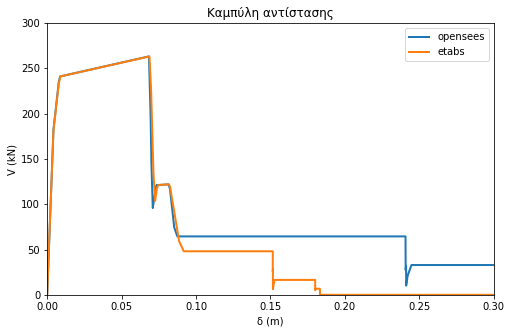

In [35]:
etabs_curve = pd.read_csv('etabs/02_userdefined.pushcurve', skiprows=7, sep='\s+')
etabs_d = etabs_curve['Displacement'].tolist()
etabs_V = etabs_curve['Base'].tolist()

f, ax = plt.subplots(figsize=(8, 5))
ax.plot(roof_displacements, -np.array(base_shears), label="opensees", lw=2)
ax.plot(etabs_d, etabs_V, label="etabs", lw=2)
ax.axis([0, 0.3, 0, 300.])
ax.set_title('Καμπύλη αντίστασης')
ax.set_ylabel('V (kN)')
ax.set_xlabel('δ (m)')
ax.legend()
fig = (f, ax)
plt.show()

In [36]:
# out['element1']
f = gzip.open('opensees/opensees_02push_out.gzpickle', 'wb', compresslevel=9)
pickle.dump(out, f)
f.close()

In [37]:
# opensees.wipe('all')